In [2]:
# ! pip install SPARQLWrapper
# TODO: Remember to mention in documentation

  Using cached SPARQLWrapper-1.8.5-py3-none-any.whl (26 kB)
  Using cached rdflib-6.1.1-py3-none-any.whl (482 kB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)


In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from SPARQLWrapper import SPARQLWrapper, JSON

In [3]:
# Reading the data from politics revisions
# Contains the revisions for all the selected items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/politics_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/politics.csv')

In [4]:
revisions.shape

(3915164, 12)

In [5]:
items.shape

(414463, 3)

Using SPARQL to retrieve the labels for all the items by using the corresponding qids

In [12]:
# Specifying the Wikidata SPARQL endpoint
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

In [45]:
# Query to access the label for the wikidata item
sparql.setQuery("""
    SELECT ?label 
    WHERE {
      wd:Q109321 rdfs:label ?label . 
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
      }
    LIMIT 1
""")

# Converting result to JSON format
sparql.setReturnFormat(JSON)
result = sparql.query().convert()
print(result)

{'head': {'vars': ['label']}, 'results': {'bindings': [{'label': {'xml:lang': 'af', 'type': 'literal', 'value': 'Albrecht Schläger'}}]}}


In [36]:
print(result["results"]["bindings"])
print(result["results"]["bindings"][0])
print(result["results"]["bindings"][0]["label"])

[{'label': {'xml:lang': 'af', 'type': 'literal', 'value': 'Albrecht Schläger'}}]
{'label': {'xml:lang': 'af', 'type': 'literal', 'value': 'Albrecht Schläger'}}
{'xml:lang': 'af', 'type': 'literal', 'value': 'Albrecht Schläger'}


In [37]:
print(result["results"]["bindings"][0]["label"]["value"])

Albrecht Schläger


In [109]:
def get_item_label(qid):
    try:        
        # Specifying the Wikidata SPARQL endpoint
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        
        # Query to access the label for the wikidata item
        sparql.setQuery('PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ?label WHERE {wd:' + qid + ' rdfs:label ?label . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } } LIMIT 1')
        
        # Converting result to JSON format
        sparql.setReturnFormat(JSON)
        result = sparql.query().convert()
        
        # result is in the form of "bindings" which are a list of dictionaries
        # Accessing the value of the label 
        itemLabel = result["results"]["bindings"][0]["label"]["value"]
        
        return itemLabel
    except Exception as ex:
        print(ex)
        return('')

In [111]:
start = time.process_time()
print(get_item_label("Q22686"))
print(time.process_time() - start)

Donald Trump
0.046875


In [ ]:
# Retrieiving labels for the items dataframe first 
# This will make the process quicker as compared to doing it for all revisions
items['label'] = [get_item_label(qid) for qid in items['qid']]

HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
HTTP Error 429: Too Many Requests
<urlopen error [WinError 10065] A socket operation was attempted to an unreachable host>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno 11001] getaddrinfo failed>
<urlopen error [Errno

# Data Cleaning

What all needs to be done?

1. The edit type needs to be redone as multiple edge cases were discovered during thedata parsing and collection stage which were not known beforehand or from sampling 10000 revisions.

- Comment - check for type such as if it is a revert, undo or if it is a predefined edit action like wbsetlabel - add:

- If of type wbset...:..../.. break the string up at the first occurrence of the colon :

- Then look at whether it is part of the edge cases wbsetlabeldescriptionaliases, .. etc and if not then it must be of type wbsetlabel- add, then look at the text before and after the dash. 

- this can probably be done by defining a method which takes in the comment, analyses it with a series of if statements, uses regex to break up the text etc and then returns 1 value for edit type or two values in a tuple for edit type and edit entity which can then be added to the dataframe using [0] and [1]

2. Remove items and their respective revisions with editcount below a certain value - need to research, find a paper on edits and do it.

3. Idea: could also lable the edits based on contributors - research paper whih categorised contributors into registered, anonymous and bots (already have a list of bots - just need to verify the data) 

4. Remove items with edits only from bots.

5. Drop unecessary rows (pageid) userid might be needed to see if the contributors are the same or not - will not need if i can confirm that usernames are unique on wikidata

6. Last or possibly at a later stage - convert the timestamp to a datetime object

In [205]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [206]:
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # Converting the comment to lowercase
    # c = comment.decode("utf-8").lower()
    c = comment.lower()
    #print(c)
    editType = '' 
    
    if c == '':
        return editType
    
    if "|" in c:
        # Comments which have |
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            editType = 'undo'
            return editType
        elif 'restore' in cc:
            editType = 'restore'
            return editType
        elif 'wbsetclaimvalue' in cc:
            editType = 'set'
            return editType
        elif 'wbsetlabeldescriptionaliases' in cc:
            editType = 'set'
            return editType
        elif 'wbcreateredirect' in cc:
            editType = 'create'
            return editType
        elif 'merge' in cc:
            editType = 'merge'
            return editType
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                editType = 'create'
                return editType
            elif 'add' in ccc:
                editType = 'add'
                return editType
            elif 'set' in ccc:
                editType = 'set'
                return editType
            elif 'update' in ccc:
                editType = 'update'
                return editType
            elif 'remove' in ccc:
                editType = 'remove'
                return editType
    if 'revert' in c: 
        editType = 'revert'
        return editType  
    elif 'protect' in c:
        editType = 'protect'
        return editType  
    elif 'undid' in c:
        editType = 'undo'
        return editType      
    return editType
        

In [207]:
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [208]:
rev.to_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/revisions_type.csv')

In [217]:
type_stats = rev['type'].value_counts()

In [229]:
# converting to a dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')

In [230]:
print(ts)

           count
type            
add      2860493
create    622289
update    286812
remove     81037
set        40207
           17761
merge       3090
undo        1470
revert      1434
restore      547
protect       24


In [234]:
tss = ts.rename(index={'': 'no type'})

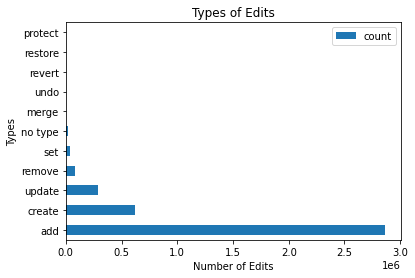

In [237]:
tss.plot.barh()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')
plt.show()

Proxies

The follwoing are those that we are interested in as they would give us more information controversial edits:

- remove
- restore
- revert
- merge
- undo 
- protected (these are in cases of vandalism - read docs and consider whether to include)

The remaining will give us general information about content being added or updated:

- create
- add
- set
- update

In [251]:
tss.iloc[[3, 6, 7, 8, 9]]

,count
type,
remove,81037
merge,3090
undo,1470
revert,1434
restore,547


In [253]:
tss.loc[['revert', 'merge', 'restore']]

,count
type,
revert,1434
merge,3090
restore,547
